# Machine Learning and Statistics for Physicists

Material for a [UC Irvine](https://uci.edu/) course offered by the [Department of Physics and Astronomy](https://www.physics.uci.edu/).

Content is maintained on [github](github.com/dkirkby/MachineLearningStatistics) and distributed under a [BSD3 license](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

Load the scikit-learn modules we need:

In [2]:
from sklearn import cluster, decomposition, metrics, manifold

## Load Data

In [3]:
from mls import locate_data

In [4]:
circles_data = pd.read_hdf(locate_data('circles_data.hf5'))
circles_targets = pd.read_hdf(locate_data('circles_targets.hf5'))

In [5]:
ess_data = pd.read_hdf(locate_data('ess_data.hf5'))
ess_targets = pd.read_hdf(locate_data('ess_targets.hf5'))

## Example: The Cure of Dimensionality

We already encountered the "curse of dimensionality" in the context of dimensionality reduction, but sometimes a large dimensionality can be a cure. As a motivating example, consider the 2D data plotted below which clearly contains two clusters with highly nonlinear shapes:

In [6]:
def plot_circles(labels, data=circles_data):
    X = data.values
    cmap = sns.color_palette('colorblind', 2)
    c = [cmap[label] for label in labels]
    plt.scatter(X[:, 0], X[:, 1], c=c)
    plt.gca().set_aspect(1)
    plt.show()

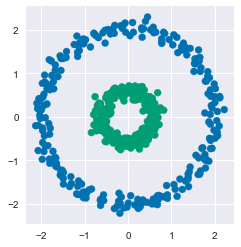

In [7]:
plot_circles(labels=circles_targets['y'])

The plot above is colored using the true labels stored as column `y` of `circles_targets`.

**EXERCISE:** Use KMeans to fit this data as two clusters and plot the results using `plot_circles(labels=fit.labels_)`.  Are the results surprising?

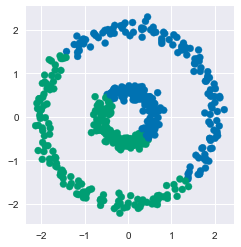

In [8]:
fit = cluster.KMeans(n_clusters=2).fit(circles_data)
plot_circles(labels = fit.labels_)

The clusters found by KMeans are not what we want, but also not surprising given that KMeans partitions samples with a simple dividing line (or hyperplane in higher dimensions).

In [9]:
# Add your solution here...

**EXERCISE:** Create a new dataset called `circles_3d` that is a copy of `circles_data` but with a new feature added:
$$
x_2 = x_0^2 + x_1^2 \; .
$$
Think about how this new feature changes the clustering problem, if at all.

In [10]:
circles_3d = circles_data.copy()
circles_3d['x2'] = circles_3d['x0'] ** 2 + circles_3d['x1'] ** 2

By *increasing* the dimensionality of our data, we have turned a very nonlinear clustering problem into a trivial linear problem!  To see this, plot the data in 3D:

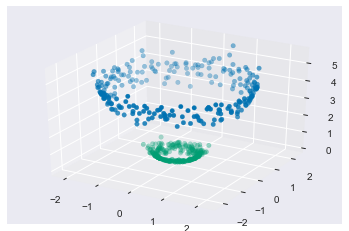

In [11]:
from mpl_toolkits.mplot3d import Axes3D

def plot_circles_3d(labels, data=circles_3d):
    X = data.values
    cmap = sns.color_palette('colorblind', 2)
    c = [cmap[label] for label in labels]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=c)
    
plot_circles_3d(labels=circles_targets['y'])

In [12]:
# Add your solution here...

**EXERCISE:** Finally, fit for 2 KMeans clusters in your new `circles_3d` data and plot the results, as above. Are the results surprising?

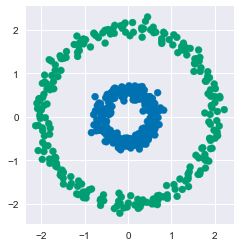

In [13]:
fit = cluster.KMeans(n_clusters=2).fit(circles_3d)
plot_circles(labels = fit.labels_)

This is exactly the result we wanted, but not surprinsingly after seeing the 3D plot above.

In [14]:
# Add your solution here...

## Kernel Functions

There are many classes of problems where nonlinearities in your data can be handled with linear methods by first embedding in a higher dimension.

The embedding we used in the example above was hand picked for that data, but a generic embedding will often work if it adds enough dimensions.  For example, the function below is commonly used to embed 2D features $(x_0, x_1)$ into a 7D space:
$$
\phi(x_0, x_1) = \begin{pmatrix}
x_0^2 \\
x_0 x_1 \\
x_1 x_0 \\
x_1^2 \\
\sqrt{2 c} x_0 \\
\sqrt{2 c} x_1 \\
c
\end{pmatrix}
$$

In [15]:
def embed(data, c=1):
    # Embed X using the poly kernel with n=2, c=1 (see p.16 of CS229 SVM notes)
    x0, x1 = data['x0'], data['x1']
    X = np.vstack([
        x0 * x0, x0 * x1, x1 * x0, x1 * x1,
        np.sqrt(2 * c) * x0, np.sqrt(2 * c) * x1,
        c + 0 * x0
    ]).T
    return pd.DataFrame(X, columns=('x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6'))

circles_embedded = embed(circles_data)

A pairplot of the 7D embedded `circles_data` shows that this is peculiar embedding, but it does allow a linear separation of the two clusters (via its $x_0^2$ and $x_1^2$ components). It also seems inefficient, with one feature repeated ($x_0 x_1$) and another one constant ($c$).  However, this is just the simplest member of a family of embeddings where $c$ plays an important role in fixing the relative normalization of the different groups of [monomials](https://en.wikipedia.org/wiki/Monomial).

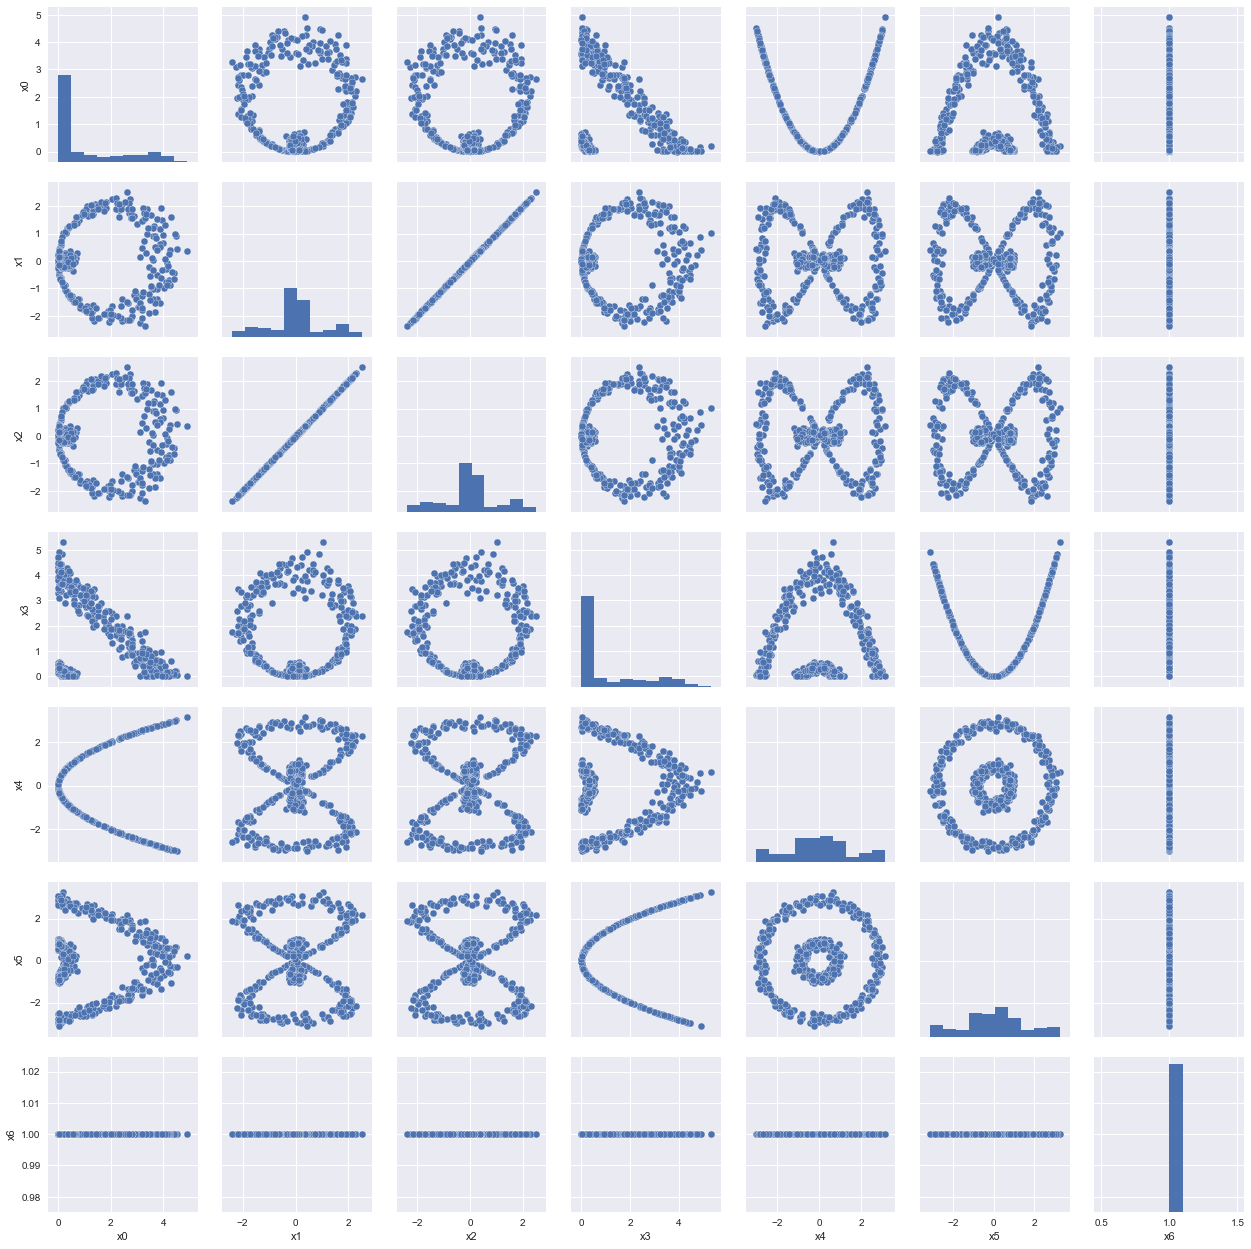

In [16]:
sns.pairplot(circles_embedded);

The reason for chosing this peculiar embedding is that it has the following very useful property:
$$
\phi(X_i) \cdot \phi(X_j) = \left(X_i\cdot X_j + c\right)^2 \; ,
$$
where $X_i$ and $X_j$ are arbitrary samples (rows) of our data.

First, lets check this explicity for `circles_data`.

In [17]:
LHS = np.einsum('ik,jk->ij', circles_embedded, circles_embedded)
RHS = (np.einsum('ik,jk->ij', circles_data, circles_data) + 1) ** 2
assert np.allclose(LHS, RHS)

The reason this property is so useful is that the RHS can be evaluated much faster than the LHS and never requires us to actually embed our original samples in the higher-dimensional space.

Functions on the sample space that evalute a dot product in a different space are called **kernel functions**:
$$
K(X_i, X_j) = \phi(X_i) \cdot \phi(X_j) \; .
$$
A kernel function is a [similarity measure](https://en.wikipedia.org/wiki/Similarity_measure) since it measures the similarity of samples $i$ and $j$, with a maximum value for identical samples and zero for orthogonal samples.  Similarity measures are related to distance measures (e.g. metrics in relativity) but with the opposite behaviour:
- very similar samples: distance ~ 0, large similarity.
- very different samples: large distance, similarity ~ 0.

The importance of kernel functions is deeper than just their computational efficiency: many algorithms can be expressed using only dot products between samples, and therefore can be applied to data embedded in a higher dimensional without ever doing the embedding.  This insight is known as the **kernel trick**:
- Pick a kernel function $K$.
- Pick an algorithm that can be expressed using only dot products.

When these pre-requisites are met, the algorithm can be easily and efficiently applied to data that is effectively boosted to a high dimensional space.  As we saw in the example above, the main benefit is that nonlinear data can now be analyzed using linear methods.

Unfortunately, there are a limited number of suitable kernel functions $K$ (start with [Mercer's theorem](https://en.wikipedia.org/wiki/Mercer%27s_theorem) if you are interested to learn more about why this is). We have already met the [polynomial kernel](https://en.wikipedia.org/wiki/Polynomial_kernel), which can be written most generally as:
$$
K(X_i, X_j) = \left( \gamma X_i\cdot X_j + c\right)^d \; ,
$$
where $\gamma$, $c$ and $d$ are all hyperparameters (our earlier example used $\gamma = 1$, $c = 1$ and $d = 2$). The `metrics.pairwise` module of sklearn can calculate the matrix of all possible sample dot products for this and other kernels, for example:

In [18]:
PK = metrics.pairwise.polynomial_kernel(circles_data, degree=2, gamma=1., coef0=1.)
assert np.allclose(LHS, PK)

Other popular kernels are the [sigmoid kernel](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.sigmoid_kernel.html):
$$
K(X_i, X_j) = \tanh\left( \gamma X_i\cdot X_j + c\right) \; ,
$$
and the [radial basis function (rbf) kernel](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html) (whose embedding is infinite dimensional due to the infinite series expansion of $e^-x$):
$$
K(X_i, X_j) = \exp\left(-\gamma \left| X_i - X_j\right|^2\right) \; .
$$

## Example: Kernel PCA

As an example of the **kernel trick**, the PCA algorithm can be adapted to use only dot products to project each sample onto the higher-dimensional eigenvectors. The resulting [KernelPCA algorithm](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html) is used just like the linear decomposition methods, but with some additional hyperparameters, e.g.
```
fit = decomposition.KernelPCA(n_components=d, kernel='poly', gamma=1., degree=2).fit(X)
Y = fit.transform(X)
```
One limitation of the kernel trick for PCA is that the original samples cannot be reconstructed using only dot products, so reconstruction of the latent variables becomes a challenging new problem that requires a [separate supervised machine learning approach](http://papers.nips.cc/paper/2417-learning-to-find-pre-images.pdf). Fortunately, the sklearn implementation takes care of all of this for you:
```
fit = decomposition.KernelPCA(n_components=d, kernel='poly', gamma=1., degree=2, inverse_transform=True).fit(X)
Y = fit.transform(X)
reconstructed = fit.inverse_transform(Y)
```

We will use the following function to demonstrate the KernelPCA method, which allows you to set the $\gamma$ hyperparameter:

In [19]:
def kpca_demo(gamma=1.0, data=circles_data, labels=circles_targets['y']):
    X = data.values
    
    # Use PCA with RBF kernel.
    kpca = decomposition.KernelPCA(kernel='rbf', gamma=gamma, n_components=2)
    reduced = kpca.fit_transform(X)
    
    # Plot 2D latent space.Results are very sensitive to choice of gamma!
    cmap = sns.color_palette('colorblind', 2)
    c = [cmap[label] for label in labels]
    plt.scatter(reduced[:, 0], reduced[:, 1], c=c)
    plt.text(0.02, 0.92, '$\gamma={:.1f}$'.format(gamma),
             transform=plt.gca().transAxes, fontsize='x-large')
    plt.xlim(-0.8, 0.8)
    plt.ylim(-0.8, 0.8)
    plt.gca().set_aspect(1)

The result is spectacular: our nonlinear data is completely linearized when transformed to a 2D latent variable space. Note that, in this example, we are not performing any overall dimensionality reduction: we started with 2 features, implicitly expanded to an infinite number of features using the RBF kernel, then shrank back down to two latent variables.

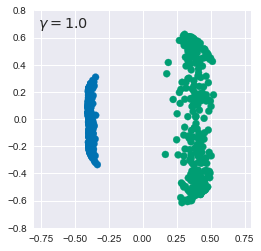

In [20]:
kpca_demo()

**EXERCISE:** The results above are quite sensitive to the choice of hyperparameters. To explore this, rerun `kpca_demo` with different values of $\gamma$.  What do you conclude?

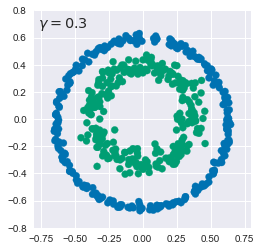

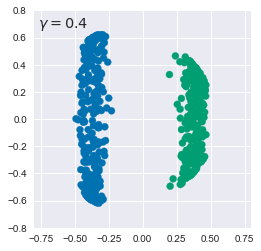

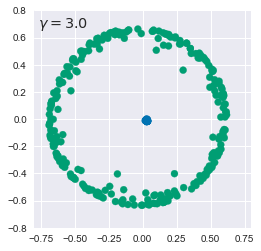

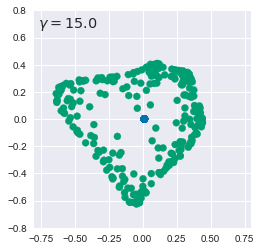

In [21]:
for gamma in (0.3, 0.4, 3., 15.):
    kpca_demo(gamma)
    plt.show()

The results are finely tuned and small variations in $\gamma$ can destroy the linear separation. Sensitivity to $\gamma$ is not too surprising since it is a parameter of the kernel function.  However, KernelPCA results can also change dramatically with a small change to the input data.  See [this github issue](https://github.com/scikit-learn/scikit-learn/issues/10530) for details.

In [22]:
# Add your solution here...

## Locally Linear Embedding

The **kernel trick** is not the only way to harness linear methods to nonlinear problems. For our next example, we consider **locally linear embedding** (LLE), which is a type of "manifold learning", i.e., a dimensionality reduction method for data on a non-linear manifold.

First lets look at some 3D data that is clearly 2D, but requires a nonlinear decomposition.

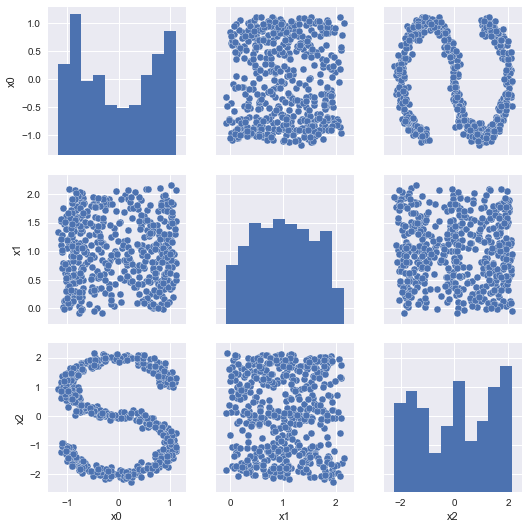

In [23]:
sns.pairplot(ess_data);

The pairplot is confusing until you see the following plot where, in addition, each point is colored according to its true 1D coordinate along the main direction of the manifold (stored in the 'y' column of `ess_targets`):

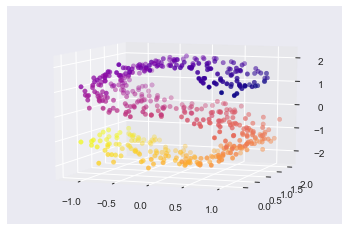

In [24]:
from mpl_toolkits.mplot3d import Axes3D

def plot_ess_3d():
    X = ess_data.values
    y = ess_targets['y']
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='plasma')
    ax.view_init(10, -70)
    
plot_ess_3d()

LLE takes advantage of the fact that the manifold is "flat" in the neighborhood of each sample, so can be described locally with a linear approximation.  We construct such a local linear approximation to a sample $\vec{X}_i$ as:
$$
\vec{X}_i \simeq \sum_{j\ne i} W_{ij} \vec{X}_j \; ,
$$
where the sum is restricted to the $n$ "nearest" samples to $X_i$. In other words, we find the set of weights $W_{ij}$ that best predict where sample $i$ based on its nearest neighbors.

We can do this for all samples simultaneously by minimizing the goal function
$$
\sum_i \left|\, \vec{X}_i - \sum_{j\ne i} W_{ij} \vec{X}_j\,\right|^2
$$
with respect to the $n\times N$ weights in $W$.

The key insight of LLE is that once a suitable set of weights $W$ have been found:
 - they fully describe the manifold's local geometry, and
 - this geometry can then be *transferred* to another (smaller) space of latent variables.
 
The way this works is we minimize a second, very similar, goal function
$$
\sum_i \left|\, \vec{Y}_i - \sum_{j\ne i} W_{ij} \vec{Y}_j\,\right|^2
$$
where each sample $X_i$ has a corresponding $Y_i$ but these can have completely different dimensions!  Note that although the goals functions look similar, the parameters we minimize are different each time:
 - We first minimize with respect to the elements of $W$, with the input data $X$ fixed.
 - Next, we minimize with respect to the latent variables $Y_i$, with the weight matrix $W$ fixed.
 
This method was discovered in 2000 and the [original paper](https://doi.org/10.1126/science.290.5500.2323) is quite accessible.

The [LLE method](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html) lives in the sklearn `manifold` module and follows the usual calling pattern, with two significant hyperparameters:
 - The number of nearest neighbors to use to calculate $W$.
 - The number of latent variables (components) to use in $Y$.

In order to get reproducible results, you should also pass in a RandomState.

In [25]:
gen = np.random.RandomState(seed=123)
fit = manifold.LocallyLinearEmbedding(n_neighbors=10, n_components=2, random_state=gen).fit(ess_data)
Y = fit.transform(ess_data)

After projecting into the latent space, we find that the S-shape has been effectively flattened out, although not to a nice rectangle:

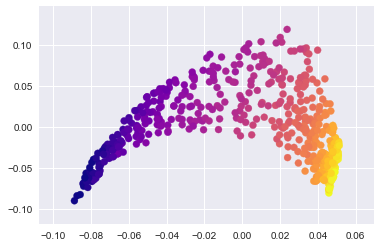

In [26]:
plt.scatter(Y[:, 0], Y[:, 1], c=ess_targets['y'], cmap='plasma')

Compare this with what a linear PCA finds:

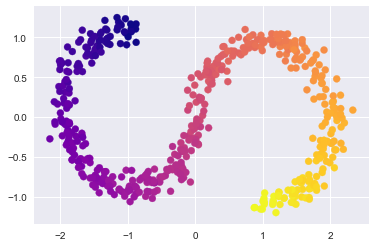

In [27]:
fit = decomposition.PCA(n_components=2, random_state=gen).fit(ess_data)
Y2 = fit.transform(ess_data)
plt.scatter(Y2[:, 0], Y2[:, 1], c=ess_targets['y'], cmap='plasma');

Or a KernelPCA:

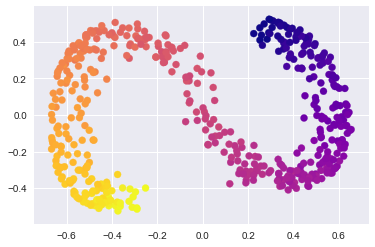

In [28]:
fit = decomposition.KernelPCA(kernel='rbf', n_components=2, random_state=gen).fit(ess_data)
Y3 = fit.transform(ess_data)
plt.scatter(Y3[:, 0], Y3[:, 1], c=ess_targets['y'], cmap='plasma');

The sklearn LLE class also provides some variants of LLE that can perform even better on this problem, for example (note the larger `n_neighbors` required - another example fine tuning):

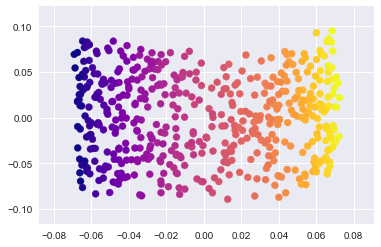

In [29]:
fit = manifold.LocallyLinearEmbedding(n_neighbors=25, n_components=2, method='ltsa', random_state=gen).fit(ess_data)
Y4 = fit.transform(ess_data)
plt.scatter(Y4[:, 0], Y4[:, 1], c=ess_targets['y'], cmap='plasma');